In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news/train.csv
/kaggle/input/fake-news/submit.csv
/kaggle/input/fake-news/test.csv


In [2]:
train_data=pd.read_csv('/kaggle/input/fake-news/train.csv')
train_data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
train_data['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

In [4]:
train_data.shape

(20800, 5)

In [5]:
train_data=train_data.dropna()
print(train_data.shape)

(18285, 5)


In [6]:
X=train_data.drop('label',axis=1)
X.head()

,id,title,author,text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...


In [7]:
y=train_data['label']

In [8]:
test_data=pd.read_csv('/kaggle/input/fake-news/test.csv')
test_data.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [9]:
from tensorflow.keras.layers import Embedding,Flatten,Dense,LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot

In [10]:
vocab_size=5000

In [11]:
import regex as re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [12]:
messages=X.copy()
messages.reset_index(inplace=True)
messages.head()

,index,id,title,author,text
0,0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."
3,3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...
4,4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...


In [13]:
ps=PorterStemmer()
corpus_train=[]
for i in range(len(messages)):
    review=re.sub('[^a-zA-Z]',' ',messages['title'][i])
    review=review.lower()
    review=review.split()
    review=[ps.stem(word) for word in review if word not in stopwords.words('english')]
    review=' '.join(review)
    corpus_train.append(review)

In [14]:
corpus_train[0:10]

['hous dem aid even see comey letter jason chaffetz tweet',
 'flynn hillari clinton big woman campu breitbart',
 'truth might get fire',
 'civilian kill singl us airstrik identifi',
 'iranian woman jail fiction unpublish stori woman stone death adulteri',
 'jacki mason hollywood would love trump bomb north korea lack tran bathroom exclus video breitbart',
 'beno hamon win french socialist parti presidenti nomin new york time',
 'back channel plan ukrain russia courtesi trump associ new york time',
 'obama organ action partner soro link indivis disrupt trump agenda',
 'bbc comedi sketch real housew isi caus outrag']

In [15]:
messages['title'][0:10]

0    House Dem Aide: We Didn’t Even See Comey’s Let...
1    FLYNN: Hillary Clinton, Big Woman on Campus - ...
2                    Why the Truth Might Get You Fired
3    15 Civilians Killed In Single US Airstrike Hav...
4    Iranian woman jailed for fictional unpublished...
5    Jackie Mason: Hollywood Would Love Trump if He...
6    Benoît Hamon Wins French Socialist Party’s Pre...
7    A Back-Channel Plan for Ukraine and Russia, Co...
8    Obama’s Organizing for Action Partners with So...
9    BBC Comedy Sketch "Real Housewives of ISIS" Ca...
Name: title, dtype: object

In [16]:
one_hot_rep=[one_hot(words,vocab_size) for words in corpus_train]
one_hot_rep[0]

[3893, 81, 441, 1114, 1311, 2824, 2869, 3527, 4351, 496]

In [17]:
sent_length=20
embedded_docs=pad_sequences(one_hot_rep,padding='pre',maxlen=sent_length)
embedded_docs[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 3893,
         81,  441, 1114, 1311, 2824, 2869, 3527, 4351,  496], dtype=int32)

In [18]:
embedded_features=40
model=Sequential()
model.add(Embedding(vocab_size,embedded_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 40)            200000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________


In [19]:
X_final=np.asarray(embedded_docs)
y_final=np.asarray(y)

In [20]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_final,y_final,random_state=42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(13713, 20) (13713,)
(4572, 20) (4572,)


In [21]:
train_model=model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10)

Train on 13713 samples, validate on 4572 samples
Epoch 1/10
13713/13713 [==============================] - 10s 748us/sample - loss: 0.2588 - accuracy: 0.8827 - val_loss: 0.1966 - val_accuracy: 0.9121
Epoch 2/10
13713/13713 [==============================] - 8s 595us/sample - loss: 0.1286 - accuracy: 0.9508 - val_loss: 0.2063 - val_accuracy: 0.9123
Epoch 3/10
13713/13713 [==============================] - 8s 573us/sample - loss: 0.0861 - accuracy: 0.9696 - val_loss: 0.2388 - val_accuracy: 0.9182
Epoch 4/10
13713/13713 [==============================] - 8s 602us/sample - loss: 0.0517 - accuracy: 0.9818 - val_loss: 0.3071 - val_accuracy: 0.9154
Epoch 5/10
13713/13713 [==============================] - 8s 586us/sample - loss: 0.0300 - accuracy: 0.9905 - val_loss: 0.3176 - val_accuracy: 0.9147
Epoch 6/10
13713/13713 [==============================] - 8s 586us/sample - loss: 0.0193 - accuracy: 0.9942 - val_loss: 0.4713 - val_accuracy: 0.9040
Epoch 7/10
13713/13713 [==========================

In [22]:
import matplotlib.pyplot as plt

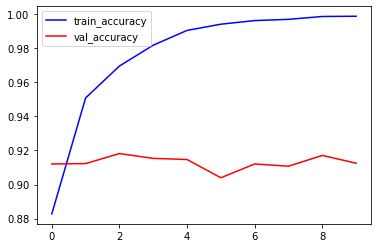

In [23]:
plt.plot(train_model.history['accuracy'],'b',label='train_accuracy')
plt.plot(train_model.history['val_accuracy'],'r',label='val_accuracy')
plt.legend()

In [24]:
def test(X):
    X=X.fillna(0)
    messages=X.copy()
    messages.reset_index(inplace=True)
    corpus=[]
    for i in range(len(messages)):
        reviews=re.sub('[^a-zA-Z]',' ',str(messages['title'][i]))
        reviews=reviews.lower()
        reviews=reviews.split()
        reviews=[ps.stem(word) for word in reviews if word not in stopwords.words('english')]
        reviews=' '.join(reviews)
        corpus.append(reviews)
    one_hot_rep=[one_hot(word,vocab_size)for word in corpus]
    embedded_docs = pad_sequences(one_hot_rep, padding = 'pre', maxlen = sent_length)
    X_final = np.array(embedded_docs)
    
    
    return X_final

In [25]:
test_data_new= test(test_data)
test_data_new[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0, 3660, 4749,
       4775, 2721,  893, 3710, 1487,  765, 2984, 2791, 1537], dtype=int32)

In [26]:
pred=model.predict(test_data_new)
print(pred.shape)

(5200, 1)


In [27]:
submission_data = pd.read_csv('/kaggle/input/fake-news/submit.csv')

In [28]:
submission_data['label']=np.round(pred).astype('int')

In [29]:
submission_data.head()

,id,label
0,20800,0
1,20801,1
2,20802,0
3,20803,0
4,20804,1


In [30]:
submission_data.to_csv('Submission.csv',index=False)